In [1]:
%matplotlib inline
import torch
import torch.nn as nn
# import pandas as pd
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.utils import save_image

(1080, 1920, 4)

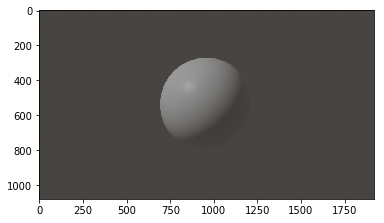

In [2]:
img = mpimg.imread('./dataset/sphere/-6.000000_6.000000.png')
# img_cropped = img[77:141, 57:121, :]
imgplot = plt.imshow(img)
# imgplot = plt.imshow(img_cropped)
img.shape

(1080, 1920)


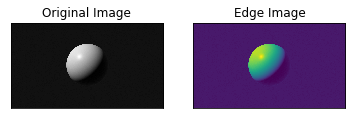

In [3]:
import cv2
img = cv2.imread('./dataset/sphere/-6.000000_6.000000.png',0)
edges = cv2.Canny(img,60,180)

print(edges.shape)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.imshow(img)

plt.show()

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [5]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, ), std=(0.5, )),
])

In [6]:
def imshow(img):
    # npimg in (channel, height, width)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [7]:
# Add file name to the label, can be iterated as follow:
# for i, data in enumerate(train_loader):
#     images,labels,paths = data
#     paths = [path.split('/')[-1] for path in paths]
#     print(paths)
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        return super(ImageFolderWithPaths, self).__getitem__(index) + (self.imgs[index][0],)

In [8]:
train_dataset = ImageFolderWithPaths(
    root='./dataset/',
    transform=transform
)
train_loader = DataLoader(
    train_dataset,
    batch_size=20,
    num_workers=5,
    shuffle=True,
    drop_last=True
)
print(train_dataset.classes)

['sphere']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([20, 1, 224, 224])


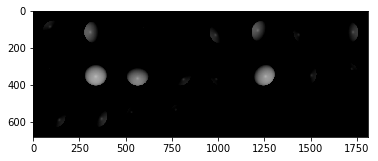

In [9]:
# get some random training images
dataiter = iter(train_loader)
quick_images, quick_labels, quick_paths = dataiter.next()

print(quick_images.shape)

# print(quick_images[0].max())
# print(quick_images[0].min())

# show images
imshow(torchvision.utils.make_grid(quick_images))

# Not sure if normalization is good or not as it darkens the image

In [10]:
img_shape = (1, 224, 224)
cuda = True if torch.cuda.is_available() else False

In [11]:
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.model = nn.Sequential(
            # Pixel Coord + Light Coord + Average Pixel Color
            nn.Linear(2 + 2 + 1, 16),
            nn.Linear(16, 16),
            nn.Linear(16, 16),
            # TODO: ADD DROPOUT
            nn.Linear(16, 1),
            nn.Tanh()
        )
    def forward(self, pixel_coord, light_coord, average_rgb):
        d_in = torch.cat((pixel_coord, light_coord, average_rgb), -1)
        rgb = self.model(d_in)
        return rgb

In [12]:
# Loss functions
loss = torch.nn.MSELoss()

# Initialize generator and discriminator
DNN = NN()

if cuda:
    DNN.cuda()
    loss.cuda()

In [13]:
# Optimizers
optimizer = torch.optim.Adam(DNN.parameters(), lr=0.002, betas=(0.9, 0.999))

In [14]:
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
CharTensor = torch.cuda.CharTensor if cuda else torch.CharTensor

In [ ]:
# Compute Average Color of All Pixels of All Images
# dic = dict()
# total_image = 0
# for i, data in enumerate(train_loader):
#     imgs,labels,paths = data
#     # x, y positions of the light
#     batch_size = imgs.shape[0]
#     num_channel = imgs.shape[1]
#     width = imgs.shape[2]
#     height = imgs.shape[3]
#     total_image += batch_size
#     # print(batch_size, num_channel, width, height)
#     for k in range(batch_size):
#         for i in range(width):
#             for j in range(height):
#                 key_name = str(i) + '-' + str(j)
#                 if key_name in dic:
#                     dic[key_name] = imgs[k, 0, i, j] + dic[key_name]
#                 else:
#                     dic[key_name] = imgs[k, 0, i, j]

In [ ]:
# avg_img = []
# for j in range(height):
#     for i in range(width):
#         key_name = str(i) + '-' + str(j)
#         avg_img += [dic[key_name] / total_image]
# total_image

In [ ]:
# avg_img = np.array(avg_img)
# print(avg_img)
# np.save('avg_img', avg_img)

In [15]:
loaded_avg_img = np.load('avg_img.npy')
img_shape = (1, 224, 224)

In [16]:
def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    # Sample noise
    width = img_shape[1]
    height = img_shape[2]
    avg_img = torch.from_numpy(loaded_avg_img).to(device)
    avg_img = Variable(avg_img.type(FloatTensor))
    img_tensor = torch.FloatTensor().to(device)
    for k in range(height):
        for j in range(width):
            # Pixel Coord + Light Coord + Average Pixel Color
            avg_value = Variable(avg_img[j + k * width].repeat(1, n_row).view(n_row, 1).type(FloatTensor))
            pixel_coord = Variable(torch.FloatTensor([j, k])).repeat(1, n_row).view(n_row, 2).to(device)
            # Default sample location is the light in the middle
            light_coord = Variable(torch.FloatTensor([0.0, 0.0])).repeat(1, n_row).view(n_row, 2).to(device)
            generate_pixel = DNN(pixel_coord, light_coord, avg_value)
            img_tensor = torch.cat((img_tensor, generate_pixel), 1)
    
    imgs = img_tensor.view(img_tensor.size(0), *img_shape)
    save_image(imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)

In [ ]:
epochs = 20
for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        # we are using paths here instead of labels
        imgs,labels,paths = data
        paths = np.array([path.split('/')[-1][:-4].split('_') for path in paths]).astype(float)
        positions = torch.from_numpy(paths).to(device)
        avg_img = torch.from_numpy(loaded_avg_img).to(device)
        imgs = imgs.to(device)
        batch_size = imgs.shape[0]
        width = imgs.shape[2]
        height = imgs.shape[3]

        # Configure input
        # Pixel Coord + Light Coord + Average Pixel Color
        avg_img = Variable(avg_img.type(FloatTensor))
        light_coord = Variable(positions.type(FloatTensor))
#         print(avg_img.shape) 
#         print(light_coord.shape)
        total_losses = 0
        for k in range(height):
            for j in range(width):
                optimizer.zero_grad()
                # Process the batch at this pixel coord
                pixel_value = Variable(imgs[:, 0, j, k].view(20, 1).type(FloatTensor))
                avg_value = Variable(avg_img[j + k * width].repeat(1, 20).view(20, 1).type(FloatTensor))
                pixel_coord = Variable(torch.FloatTensor([j, k])).repeat(1, 20).view(20, 2).to(device)
                generate_pixel = DNN(pixel_coord, light_coord, avg_value)
                # Image with all lighting conditions
                total_loss = loss(generate_pixel, pixel_value)
                total_losses += total_loss.item()
                if j == width/2 and k == width/2:
                    print(
                    "[Epoch %d/%d] [Batch %d/%d] [Pixel %d-%d] [Loss: %f]"
                    % (epoch + 1, epochs, i + 1, len(train_loader), j, k, total_loss)
                    )
                total_loss.backward()
                optimizer.step()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [Total loss: %f]"
            % (epoch + 1, epochs, i + 1, len(train_loader), total_losses)
        )

        batches_done = epoch * len(train_loader) + i
        if batches_done % 1 == 0:
            sample_image(n_row=20, batches_done=batches_done)

[Epoch 1/20] [Batch 1/6] [Pixel 112-112] [Loss: 0.117736]
[Epoch 1/20] [Batch 1/6] [Total loss: 1320.645051]
[Epoch 1/20] [Batch 2/6] [Pixel 112-112] [Loss: 0.048211]
[Epoch 1/20] [Batch 2/6] [Total loss: 880.771820]
[Epoch 1/20] [Batch 3/6] [Pixel 112-112] [Loss: 0.070705]
[Epoch 1/20] [Batch 3/6] [Total loss: 1238.721800]
[Epoch 1/20] [Batch 4/6] [Pixel 112-112] [Loss: 0.065100]
[Epoch 1/20] [Batch 4/6] [Total loss: 1071.570787]
[Epoch 1/20] [Batch 5/6] [Pixel 112-112] [Loss: 0.047173]
[Epoch 1/20] [Batch 5/6] [Total loss: 958.905069]
[Epoch 1/20] [Batch 6/6] [Pixel 112-112] [Loss: 0.094802]
[Epoch 1/20] [Batch 6/6] [Total loss: 1480.369363]
[Epoch 2/20] [Batch 1/6] [Pixel 112-112] [Loss: 0.073425]
[Epoch 2/20] [Batch 1/6] [Total loss: 1109.755375]
[Epoch 2/20] [Batch 2/6] [Pixel 112-112] [Loss: 0.050927]
[Epoch 2/20] [Batch 2/6] [Total loss: 936.795954]
[Epoch 2/20] [Batch 3/6] [Pixel 112-112] [Loss: 0.045407]
[Epoch 2/20] [Batch 3/6] [Total loss: 997.766246]
[Epoch 2/20] [Batch 4/6

[Epoch 13/20] [Batch 4/6] [Total loss: 922.903213]
[Epoch 13/20] [Batch 5/6] [Pixel 112-112] [Loss: 0.052334]
[Epoch 13/20] [Batch 5/6] [Total loss: 928.052773]
[Epoch 13/20] [Batch 6/6] [Pixel 112-112] [Loss: 0.096692]
[Epoch 13/20] [Batch 6/6] [Total loss: 1116.084989]
[Epoch 14/20] [Batch 1/6] [Pixel 112-112] [Loss: 0.058086]
[Epoch 14/20] [Batch 1/6] [Total loss: 863.444058]
[Epoch 14/20] [Batch 2/6] [Pixel 112-112] [Loss: 0.087583]
[Epoch 14/20] [Batch 2/6] [Total loss: 1011.919824]
[Epoch 14/20] [Batch 3/6] [Pixel 112-112] [Loss: 0.100757]
[Epoch 14/20] [Batch 3/6] [Total loss: 1064.354267]
[Epoch 14/20] [Batch 4/6] [Pixel 112-112] [Loss: 0.062316]
[Epoch 14/20] [Batch 4/6] [Total loss: 986.324507]
[Epoch 14/20] [Batch 5/6] [Pixel 112-112] [Loss: 0.045929]
[Epoch 14/20] [Batch 5/6] [Total loss: 592.708822]
[Epoch 14/20] [Batch 6/6] [Pixel 112-112] [Loss: 0.069646]
[Epoch 14/20] [Batch 6/6] [Total loss: 872.099761]
[Epoch 15/20] [Batch 1/6] [Pixel 112-112] [Loss: 0.068819]
[Epoch 